In [113]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics
import branca

import shared_utils
import utils

from siuba import *
import pandas as pd
import geopandas as gpd
import shapely

import datetime as dt
import time
from zoneinfo import ZoneInfo

import rt_analysis as rt
import importlib

import gcsfs
fs = gcsfs.GCSFileSystem()

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

In [150]:
importlib.reload(utils)
importlib.reload(rt)

<module 'rt_analysis' from '/home/jovyan/data-analyses/rt_delay/rt_analysis.py'>

In [129]:
sjrtd_itp_id = 284

In [130]:
analysis_date = dt.date(2022, 2, 8)

In [131]:
pbar = tqdm()

0it [00:00, ?it/s]

In [132]:
sjrtd = rt.OperatorDayAnalysis(sjrtd_itp_id, analysis_date, pbar)

found parquet
found parquet
found parquet
found parquet
found_parquet
less than 1km of data
vehicle positions gdf must not be empty
less than 1km of data
less than 1km of data
less than 1km of data
less than 1km of data
less than 1km of data
less than 1km of data
less than 1km of data
less than 1km of data
less than 1km of data
less than 1km of data
less than 1km of data
less than 1km of data
less than 1km of data
less than 1km of data
could not generate delays for trip 257117
Columns must be same length as key
could not generate delays for trip 257127
Columns must be same length as key
could not generate delays for trip 255934
Columns must be same length as key


In [145]:
sjrtd.set_filter(start_time='15:00', end_time='19:00')

In [151]:
rt.OperatorDayAnalysis.set_filter(sjrtd, start_time='15:00', end_time='19:00', route_ids=['44', '47'])

{'start_time': datetime.time(15, 0), 'end_time': datetime.time(19, 0), 'route_ids': ['44', '47'], 'direction_id': None, 'direction': None}


In [134]:
m = rt.OperatorDayAnalysis.segment_speed_map(sjrtd)

view filter: {'start_time': datetime.time(15, 0), 'end_time': datetime.time(19, 0), 'route_ids': None, 'direction_id': None, 'direction': None}
speed above 80 for shape 32100, dropping
negative speed for shape 32100, dropping
speed above 80 for shape 32140, dropping
negative speed for shape 32140, dropping
speed above 80 for shape 32111, dropping
negative speed for shape 32111, dropping
speed above 80 for shape 32109, dropping
negative speed for shape 32109, dropping
speed above 80 for shape 32197, dropping
negative speed for shape 32197, dropping
speed above 80 for shape 32222, dropping
negative speed for shape 32114, dropping
negative speed for shape 32102, dropping
speed above 80 for shape 32103, dropping
negative speed for shape 32103, dropping
speed above 80 for shape 32105, dropping


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract


speed above 80 for shape 32116, dropping
negative speed for shape 32116, dropping
negative speed for shape 32163, dropping
speed above 80 for shape 32183, dropping
negative speed for shape 32183, dropping


TopologyException: assigned depths do not match at -116060.80090243505 1239.5472101856335
TopologyException: assigned depths do not match at -117953.55795454726 1648.8320321653728
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:634: ShapelyDeprecationWarning: GeometryTypeError will derive from ShapelyError and not TypeError or ValueError in Shapely 2.0.
Input geom 1 is INVALID: Self-intersection at or near point -112002.82831454017 10863.90563969472 (-112002.82831454016559 10863.905639694719866)
<A>
MULTIPOLYGON (((-114084.0060600302240346 11813.8892132562868937, -114133.6894329562346684 11835.6277149225752510, -114083.3837823768844828 11855.8846031285356730, -114084.0060600302240346 11813.8892132562868937)), ((-112001.2387243993725860 10858.0429960649416898, -112014.0182606407324784 10905.1758165411702066, -111999.0615781328669982 10919.9168357853995985, -112001.2387243993725860 10858.0429960649416898)), ((-112002.8088594820874278 10863.8859000062984705, -112014.0182606407324784

In [135]:
sjrtd.calitp_agency_name

'San Joaquin Regional Transit District'

In [136]:
sjrtd.analysis_date

datetime.date(2022, 2, 8)

In [137]:
# sjrtd.display_date = sjrtd.analysis_date.strftime('%b %d (%a)')

In [138]:
sjrtd.display_date

'Feb 08 (Tue)'

In [152]:
sjrtd.filter_formatted

', Route(s) 44, 47, PM Peak, Feb 08 (Tue)'

In [102]:
# m

In [85]:
rt_1 = sjrtd.endpoint_delay_summary >> filter(_.route_id == '44', _.direction_id == '0')

In [86]:
rt_1['Minutes of Delay at Endpoint'] = rt_1.mean_end_delay.apply(lambda x: x.seconds / 60)
rt_1['Hour'] = rt_1.arrival_hour

/tmp/ipykernel_864/2582780535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_864/2582780535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


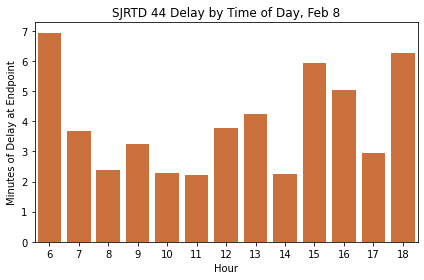

In [87]:
sns_plot = (sns.barplot(x=rt_1['Hour'], y=rt_1['Minutes of Delay at Endpoint'], ci=None, 
                       palette=[shared_utils.calitp_color_palette.CALITP_CATEGORY_BOLD_COLORS[1]])
            .set_title("SJRTD 44 Delay by Time of Day, Feb 8")
           )
chart3 = sns_plot.get_figure()
chart3.tight_layout()
chart3.savefig("./seaborn_chart.png")

In [21]:
import seaborn as sns

In [11]:
sjrtd.endpoint_delay_view >> filter(_.direction_id == '1', _.route_id == '44', _.arrival_hour == 17)

,stop_id,stop_name,geometry,shape_id,shape_meters,trip_key,trip_id,stop_sequence,arrival_time,route_id,direction_id,actual_time,delay,arrival_hour
604,4262,B ST & INDUSTRIAL FS SB,POINT (-109482.238 -10892.097),32167,8788.228657,7634748224816367213,256430,10,2022-02-08 17:10:00,44,1,2022-02-08 17:14:05.325188,0 days 00:04:05.325188,17
619,4262,B ST & INDUSTRIAL FS SB,POINT (-109482.238 -10892.097),32167,8788.228657,6213570986177580474,256432,10,2022-02-08 17:50:00,44,1,2022-02-08 18:01:08.942307,0 days 00:11:08.942307,17
631,4262,B ST & INDUSTRIAL FS SB,POINT (-109482.238 -10892.097),32167,8788.228657,-2432284056693972957,256431,10,2022-02-08 17:30:00,44,1,2022-02-08 17:30:21.678343,0 days 00:00:21.678343,17


In [12]:
rt_delay_joined = sjrtd.rt_trips >> inner_join(_, sjrtd.endpoint_delay_view >> select(_.trip_id, _.endpoint_delay == _.delay,
                                                                      _.arrival_hour)
                              , on = 'trip_id')

In [18]:
rt_delay_joined >> arrange(_.mean_speed_mph) >> head(20)

,calitp_itp_id,calitp_url_number,service_date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,median_time,direction,mean_speed_mph,endpoint_delay,arrival_hour
499,284,0,2022-02-08,-7120683714005136137,256762,515,0,32182,2022-01-27,2099-01-01,11:35:46,Eastbound,2.668024,0 days 00:00:34.884628,11
570,284,0,2022-02-08,6646203835683139758,256763,515,0,32182,2022-01-27,2099-01-01,12:31:35,Eastbound,4.252582,0 days 00:03:14.124990,12
237,284,0,2022-02-08,-5871421935972953161,256555,47,1,32173,2022-01-27,2099-01-01,11:06:38,Westbound,4.793706,0 days 00:00:00,10
253,284,0,2022-02-08,-6541893868271016968,256024,40,0,32161,2022-01-27,2099-01-01,14:35:22.500000,Northbound,4.874452,0 days 00:02:46.615669,14
758,284,0,2022-02-08,1338754799125925826,256920,578,1,32204,2022-01-27,2099-01-01,13:21:14,Southbound,5.259841,0 days 00:35:33.021487,13
710,284,0,2022-02-08,-19567041762988397,256560,47,1,32173,2022-01-27,2099-01-01,13:46:35,Westbound,5.584358,0 days 00:00:24.516503,13
507,284,0,2022-02-08,-6763193540224585276,256531,47,0,32169,2022-01-27,2099-01-01,13:08:44.500000,Eastbound,5.930144,0 days 00:04:18.885762,13
482,284,0,2022-02-08,4387404246973415212,256655,49,1,32177,2022-01-27,2099-01-01,09:29:39,Westbound,5.995747,0 days 00:07:21.211329,9
532,284,0,2022-02-08,7225927332437514028,256679,49,1,32177,2022-01-27,2099-01-01,18:03:07,Westbound,6.024031,0 days 00:10:13.306566,18
376,284,0,2022-02-08,1620775632447595493,256674,49,1,32177,2022-01-27,2099-01-01,16:29:51,Westbound,6.026893,0 days 00:02:49.292536,16


In [14]:
dt1 = sjrtd.position_interpolators['256383']['rt']

In [15]:
dt2 = sjrtd.position_interpolators['256519']['rt']